The first cells are just copies from the previous lesson to start clean 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError
import warnings
from sklearn.preprocessing import MinMaxScaler
import sys
sys.path.append('../classes')
from my_window import DataWindow,MetaBaselineDataWindow #type: ignore
from baseline import Baseline,MultiStepLastBaseline,MetaBaseline,AverageBaseline,CopyBaseline,LastValueBaseline,RepeatBaseline #type: ignore

warnings.filterwarnings('ignore')

109/109 [==============================] - 1s 2ms/step - loss: 0.1022 - mean_absolute_error: 0.2668
0.2552611529827118
110/110 [==============================] - 0s 2ms/step - loss: 0.0133 - mean_absolute_error: 0.0831
0.08128398656845093
[0.10219626128673553, 0.26676443219184875]
[0.01331727858632803, 0.08305124193429947]


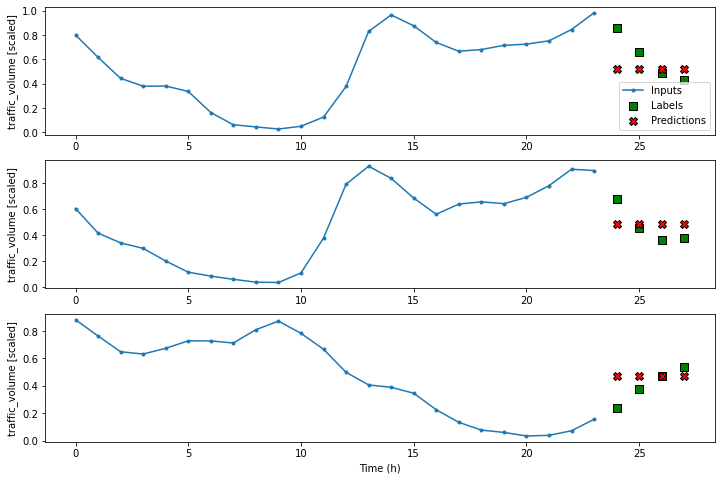

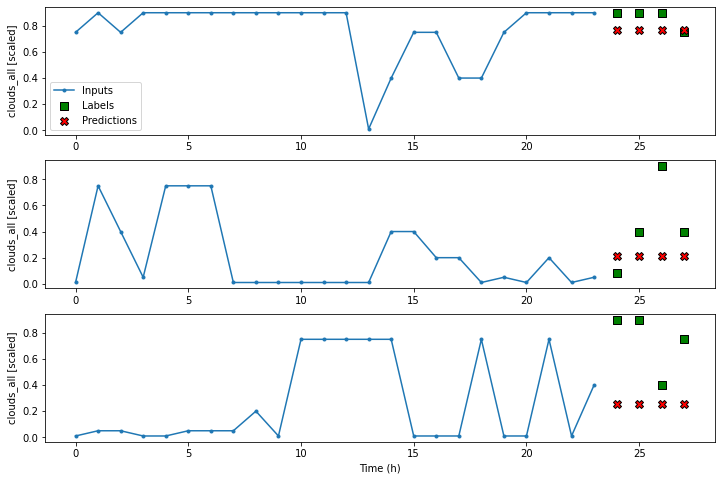

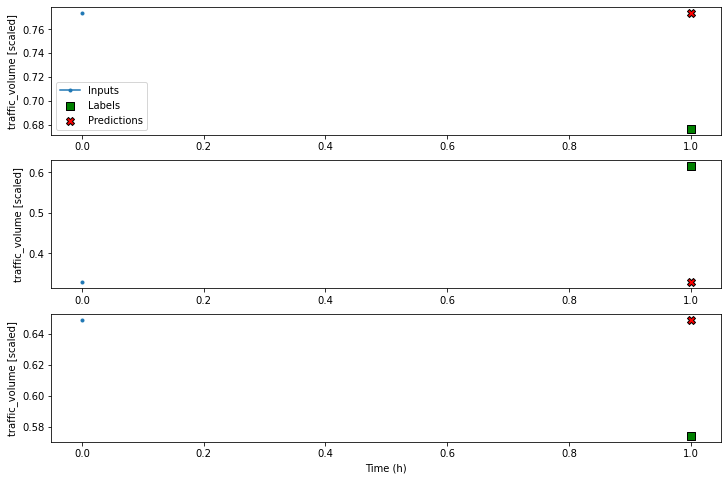

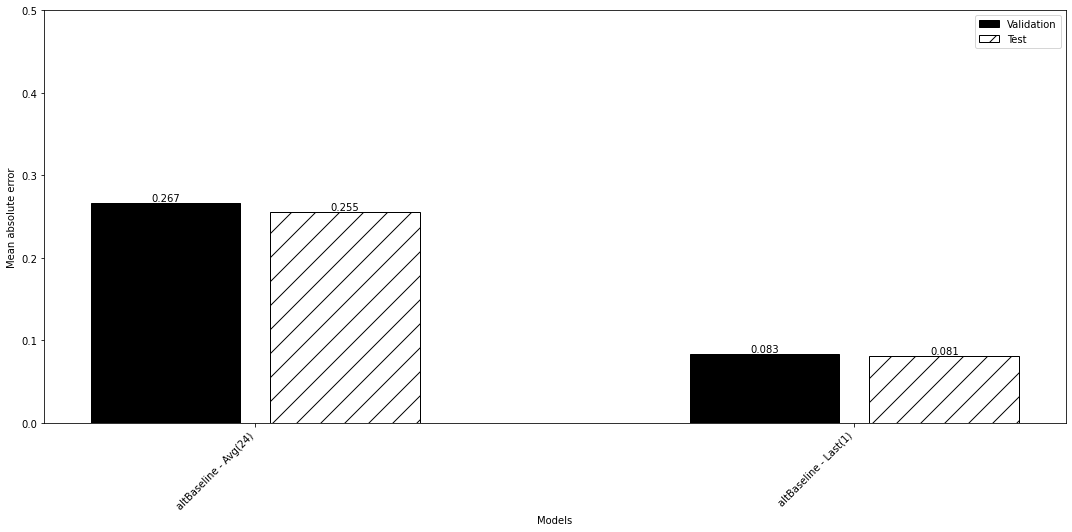

In [3]:
train_df = pd.read_csv('../data/train.csv', index_col=0)
val_df = pd.read_csv('../data/val.csv', index_col=0)
test_df = pd.read_csv('../data/test.csv', index_col=0)
scaler = MinMaxScaler()
scaler.fit(train_df)
wide_window = DataWindow(input_width=24, label_width=24, shift=1, label_columns=['traffic_volume'])
train_df[train_df.columns] = scaler.transform(train_df[train_df.columns])
val_df[val_df.columns] = scaler.transform(val_df[val_df.columns])
test_df[test_df.columns] = scaler.transform(test_df[test_df.columns])

val_performance = {}
performance = {}

alt_baseline_last = AverageBaseline(label_columns=['traffic_volume','clouds_all'],input_window_size=24,output_prediction_window_size=4)
alt_baseline_last.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])
single_step_window = MetaBaselineDataWindow(input_width=8, label_width=4, shift=4, label_columns=['traffic_volume','clouds_all']) 
single_step_window2 = MetaBaselineDataWindow(model=alt_baseline_last)
val_performance['altBaseline - Avg(24)'] = alt_baseline_last.evaluate(single_step_window2.val)
performance['altBaseline - Avg(24)'] = alt_baseline_last.evaluate(single_step_window2.test, verbose=0)
print(performance['altBaseline - Avg(24)'][1])
single_step_window2.plot_upg()

alt_baseline_last = LastValueBaseline(label_columns=['traffic_volume'],input_window_size=1,output_prediction_window_size=1)
alt_baseline_last.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])
single_step_window2 = MetaBaselineDataWindow(model=alt_baseline_last)
val_performance['altBaseline - Last(1)'] = alt_baseline_last.evaluate(single_step_window2.val)
performance['altBaseline - Last(1)'] = alt_baseline_last.evaluate(single_step_window2.test, verbose=0)
print(performance['altBaseline - Last(1)'][1])
single_step_window2.plot_upg()
plt.rcParams['figure.figsize'] = (15, 7.5)
plt.rcParams['axes.grid'] = False
def print_perf(_performance=performance,_val_performance=val_performance):
    mae_val = [v[1] for v in _val_performance.values()]
    mae_test = [v[1] for v in _performance.values()]
    
    x = np.arange(len(_performance))
    
    for v in _val_performance.values():
        print(v)
    
    fig, ax = plt.subplots()
    ax.bar(x - 0.15, mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
    ax.bar(x + 0.15, mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
    ax.set_ylabel('Mean absolute error')
    ax.set_xlabel('Models')
    
    for index, value in enumerate(mae_val):
        plt.text(x=index - 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')
        
    for index, value in enumerate(mae_test):
        plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')
    
    ax.set_xticks(x)
    ax.set_xticklabels(_performance.keys(), rotation=45, ha='right')
    
    plt.ylim(0, 0.5)
    plt.xticks(ticks=x, labels=_performance.keys())
    plt.legend(loc='best')
    plt.tight_layout()

print_perf()

In [4]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense

Let's simplify the task for us by creating a function to handle kind of everything for us. It takes a DataWindow and a model and fits the model to the window dataset.
To fit the model, we specify a maximum number of epochs, i.e., the number of time the dataset (sliced) is processed for the fit.
On top of that, we add EarlyStopping that will break the fitting process when no improvement is attained after a certain number of epochs. This number of tolerance is called patience.

In [5]:
def compile_and_fit(model, window, patience=3, max_epochs=50):
    early_stopping = EarlyStopping(monitor='val_loss',
                                   patience=patience,
                                   mode='min')
    
    model.compile(loss=MeanSquaredError(),
                  optimizer=Adam(),
                  metrics=[MeanAbsoluteError()])
    
    _history = model.fit(window.train,
                       epochs=max_epochs,
                       validation_data=window.val,
                       callbacks=[early_stopping])
    
    return _history

# Simple linear regression 

The linear regression can be seen as a perceptron https://datascientest.com/wp-content/uploads/2021/04/illu_perceptron_blog-138.png.
I

Epoch 1/50
384/384 [==============================] - 2s 3ms/step - loss: 0.1709 - mean_absolute_error: 0.3375 - val_loss: 0.0923 - val_mean_absolute_error: 0.2468
Epoch 2/50
384/384 [==============================] - 1s 3ms/step - loss: 0.0641 - mean_absolute_error: 0.2043 - val_loss: 0.0361 - val_mean_absolute_error: 0.1553
Epoch 3/50
384/384 [==============================] - 1s 3ms/step - loss: 0.0266 - mean_absolute_error: 0.1313 - val_loss: 0.0188 - val_mean_absolute_error: 0.1127
Epoch 4/50
384/384 [==============================] - 1s 3ms/step - loss: 0.0152 - mean_absolute_error: 0.0974 - val_loss: 0.0131 - val_mean_absolute_error: 0.0909
Epoch 5/50
384/384 [==============================] - 1s 4ms/step - loss: 0.0115 - mean_absolute_error: 0.0805 - val_loss: 0.0108 - val_mean_absolute_error: 0.0790
Epoch 6/50
384/384 [==============================] - 2s 4ms/step - loss: 0.0101 - mean_absolute_error: 0.0727 - val_loss: 0.0098 - val_mean_absolute_error: 0.0721
Epoch 7/50
384/3

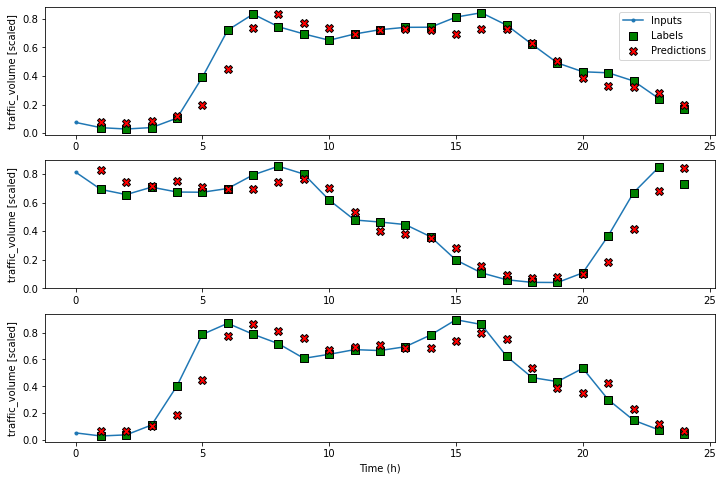

In [6]:
single_step_window = MetaBaselineDataWindow(input_width=1, label_width=1, shift=1, label_columns=['traffic_volume']) 

linear1 = Sequential([
    Dense(units=1)
])
history = compile_and_fit(linear1, single_step_window)

val_performance['Linear 1'] = linear1.evaluate(single_step_window.val)
performance['Linear 1'] = linear1.evaluate(single_step_window.test, verbose=0)
wide_window.plot(linear1)

the input here is five elements. these are the columns of the dataset.

In [7]:
input_shape = linear1.input_shape
num_input_units = input_shape[-1]
print("Number of units in the input layer:", num_input_units)
train_df.head()

Number of units in the input layer: 5


,temp,clouds_all,traffic_volume,day_sin,day_cos
0,0.760019,0.0,0.758755,0.146447,0.853553
1,0.738174,0.0,0.560765,0.250000,0.933013
2,0.698884,0.0,0.463513,0.370590,0.982963
3,0.668238,0.0,0.370029,0.500000,1.000000
4,0.643093,0.0,0.325101,0.629410,0.982963


We can try to predict the next label using the 24 hours before, but it seems performances are lowered.

Epoch 1/50
384/384 [==============================] - 4s 7ms/step - loss: 0.1503 - mean_absolute_error: 0.3143 - val_loss: 0.1183 - val_mean_absolute_error: 0.2838
Epoch 2/50
384/384 [==============================] - 2s 6ms/step - loss: 0.1006 - mean_absolute_error: 0.2640 - val_loss: 0.0967 - val_mean_absolute_error: 0.2608
Epoch 3/50
384/384 [==============================] - 2s 5ms/step - loss: 0.0865 - mean_absolute_error: 0.2498 - val_loss: 0.0883 - val_mean_absolute_error: 0.2523
Epoch 4/50
384/384 [==============================] - 2s 5ms/step - loss: 0.0815 - mean_absolute_error: 0.2453 - val_loss: 0.0850 - val_mean_absolute_error: 0.2490
Epoch 5/50
384/384 [==============================] - 2s 6ms/step - loss: 0.0789 - mean_absolute_error: 0.2430 - val_loss: 0.0826 - val_mean_absolute_error: 0.2471
Epoch 6/50
384/384 [==============================] - 2s 6ms/step - loss: 0.0774 - mean_absolute_error: 0.2414 - val_loss: 0.0814 - val_mean_absolute_error: 0.2461
Epoch 7/50
384/3

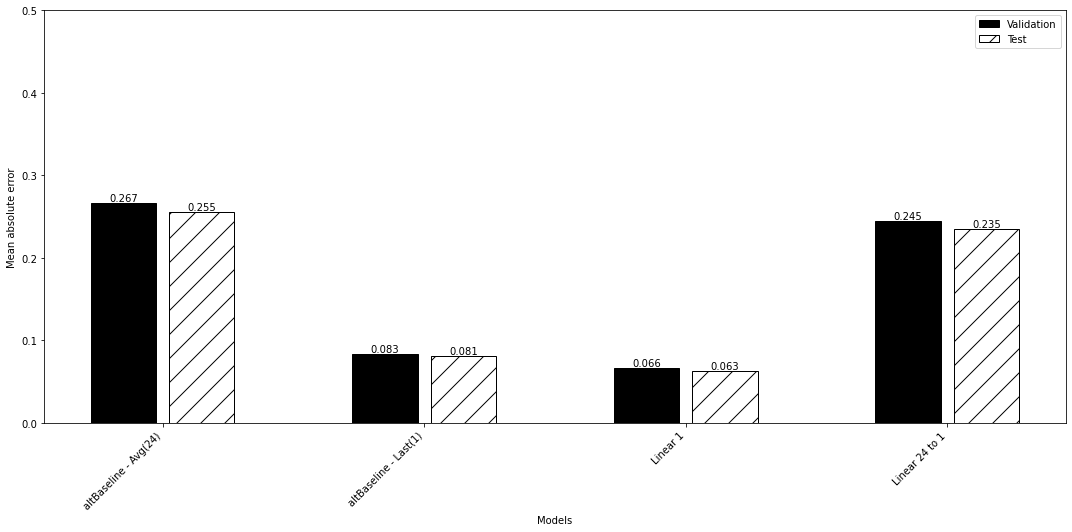

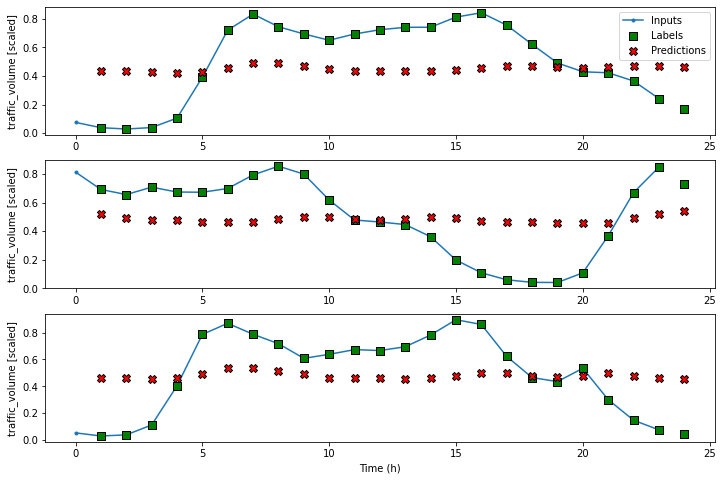

In [8]:
single_step_window = DataWindow(input_width=24, label_width=1, shift=1, label_columns=['traffic_volume']) 

linear24 = Sequential([
    Dense(units=1)
])
history = compile_and_fit(linear24, single_step_window)
val_performance['Linear 24 to 1'] = linear24.evaluate(single_step_window.val)
performance['Linear 24 to 1'] = linear24.evaluate(single_step_window.test, verbose=0)
print_perf()
wide_window.plot(linear24)


this time we try to predict a full day using last day!

Epoch 1/50
383/383 [==============================] - 3s 6ms/step - loss: 0.0901 - mean_absolute_error: 0.2469 - val_loss: 0.0459 - val_mean_absolute_error: 0.1824
Epoch 2/50
383/383 [==============================] - 2s 5ms/step - loss: 0.0299 - mean_absolute_error: 0.1370 - val_loss: 0.0261 - val_mean_absolute_error: 0.1253
Epoch 3/50
383/383 [==============================] - 2s 5ms/step - loss: 0.0201 - mean_absolute_error: 0.1045 - val_loss: 0.0212 - val_mean_absolute_error: 0.1073
Epoch 4/50
383/383 [==============================] - 2s 6ms/step - loss: 0.0177 - mean_absolute_error: 0.0954 - val_loss: 0.0196 - val_mean_absolute_error: 0.1001
Epoch 5/50
383/383 [==============================] - 2s 6ms/step - loss: 0.0168 - mean_absolute_error: 0.0914 - val_loss: 0.0188 - val_mean_absolute_error: 0.0955
Epoch 6/50
383/383 [==============================] - 2s 5ms/step - loss: 0.0164 - mean_absolute_error: 0.0887 - val_loss: 0.0185 - val_mean_absolute_error: 0.0923
Epoch 7/50
383/3

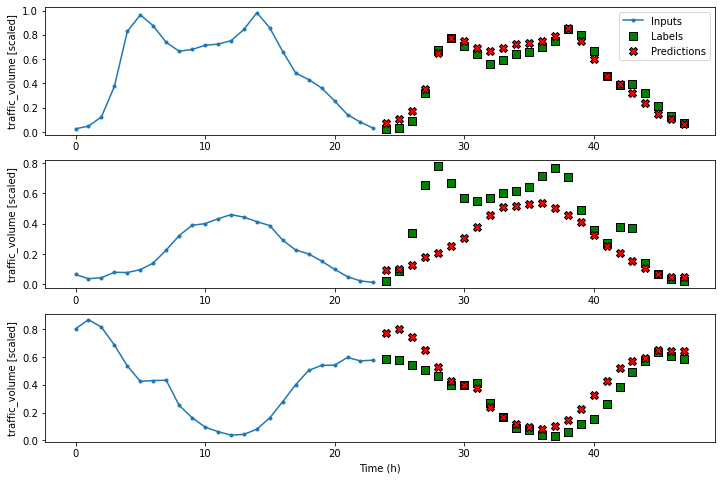

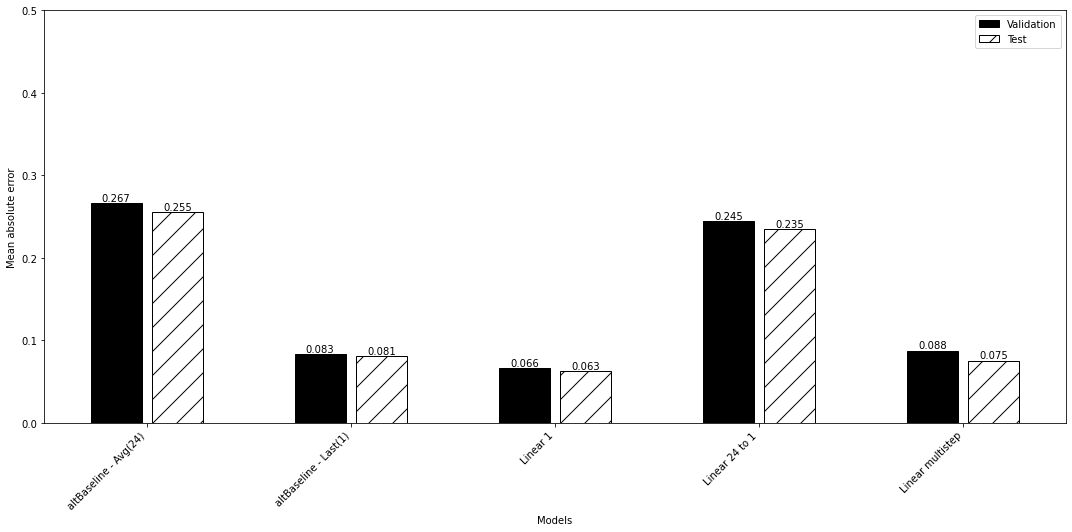

In [9]:
multi_window = DataWindow(input_width=24, label_width=24, shift=24, label_columns=['traffic_volume'])
ms_linear = Sequential([
    Dense(1, kernel_initializer=tf.initializers.zeros)
])

history = compile_and_fit(ms_linear, multi_window)

val_performance['Linear multistep'] = ms_linear.evaluate(multi_window.val)
performance['Linear multistep'] = ms_linear.evaluate(multi_window.test, verbose=0)

multi_window.plot(ms_linear)
print_perf()

now if we predict two values, we need two units! 

<div style="background-color:white;">
    <img src="../figures/figure_multi.png" alt="My Image">
</div>


Epoch 1/50
384/384 [==============================] - 3s 5ms/step - loss: 0.6988 - mean_absolute_error: 0.6876 - val_loss: 0.2800 - val_mean_absolute_error: 0.4393
Epoch 2/50
384/384 [==============================] - 2s 4ms/step - loss: 0.1500 - mean_absolute_error: 0.3202 - val_loss: 0.0930 - val_mean_absolute_error: 0.2567
Epoch 3/50
384/384 [==============================] - 2s 4ms/step - loss: 0.0641 - mean_absolute_error: 0.2115 - val_loss: 0.0489 - val_mean_absolute_error: 0.1838
Epoch 4/50
384/384 [==============================] - 2s 5ms/step - loss: 0.0355 - mean_absolute_error: 0.1559 - val_loss: 0.0283 - val_mean_absolute_error: 0.1385
Epoch 5/50
384/384 [==============================] - 2s 5ms/step - loss: 0.0216 - mean_absolute_error: 0.1202 - val_loss: 0.0178 - val_mean_absolute_error: 0.1097
Epoch 6/50
384/384 [==============================] - 2s 6ms/step - loss: 0.0145 - mean_absolute_error: 0.0970 - val_loss: 0.0125 - val_mean_absolute_error: 0.0908
Epoch 7/50
384/3

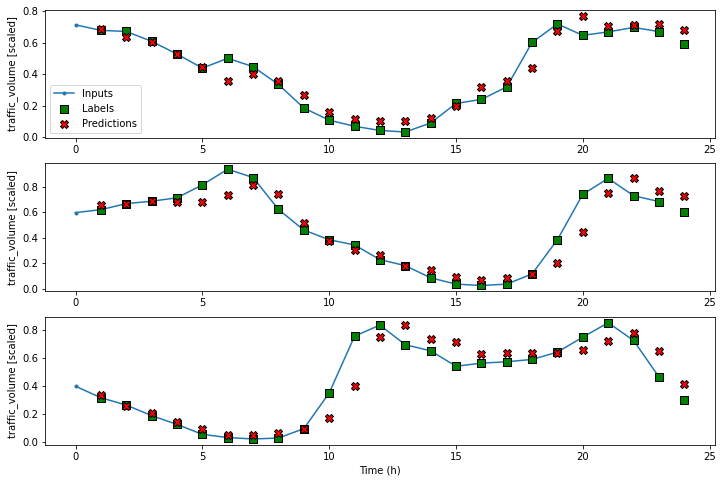

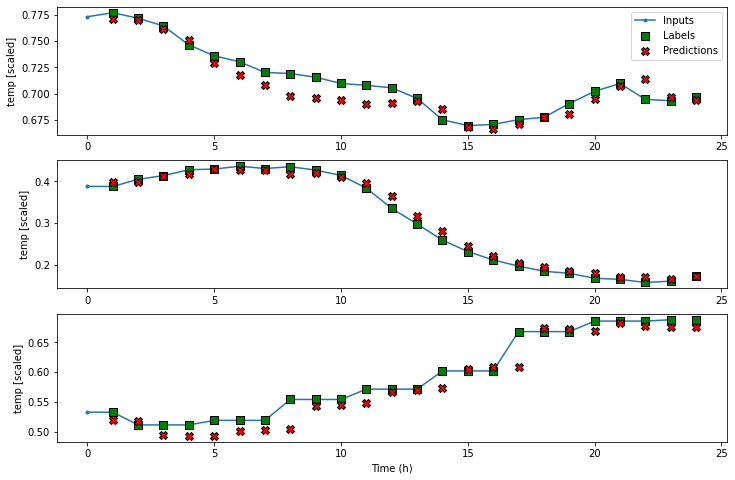

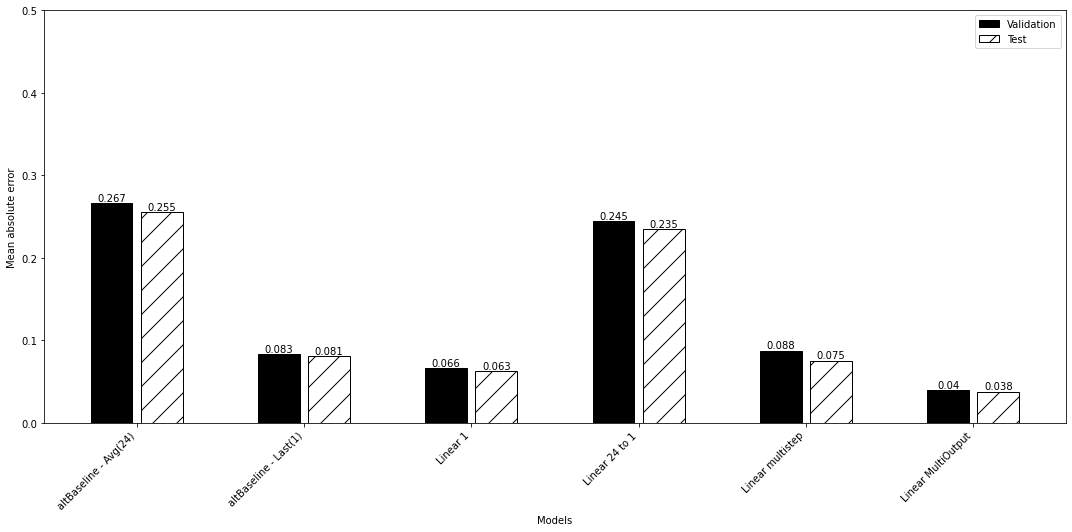

In [10]:
mo_single_step_window = DataWindow(input_width=1, label_width=1, shift=1, label_columns=['temp','traffic_volume']) 
mo_wide_window = DataWindow(input_width=24, label_width=24, shift=1, label_columns=['temp','traffic_volume'])

mo_linear = Sequential([
    Dense(units=2)
])

history = compile_and_fit(mo_linear, mo_single_step_window)

val_performance['Linear MultiOutput'] = mo_linear.evaluate(mo_single_step_window.val)
performance['Linear MultiOutput'] = mo_linear.evaluate(mo_single_step_window.test, verbose=0)

mo_wide_window.plot(mo_linear)
mo_wide_window.plot(mo_linear,plot_col='temp')
print_perf()

Epoch 1/50
384/384 [==============================] - 2s 4ms/step - loss: 0.1053 - mean_absolute_error: 0.2583 - val_loss: 0.0574 - val_mean_absolute_error: 0.1949
Epoch 2/50
384/384 [==============================] - 1s 4ms/step - loss: 0.0373 - mean_absolute_error: 0.1537 - val_loss: 0.0259 - val_mean_absolute_error: 0.1236
Epoch 3/50
384/384 [==============================] - 1s 4ms/step - loss: 0.0178 - mean_absolute_error: 0.1041 - val_loss: 0.0127 - val_mean_absolute_error: 0.0871
Epoch 4/50
384/384 [==============================] - 1s 4ms/step - loss: 0.0095 - mean_absolute_error: 0.0753 - val_loss: 0.0074 - val_mean_absolute_error: 0.0641
Epoch 5/50
384/384 [==============================] - 2s 4ms/step - loss: 0.0063 - mean_absolute_error: 0.0572 - val_loss: 0.0055 - val_mean_absolute_error: 0.0505
Epoch 6/50
384/384 [==============================] - 1s 4ms/step - loss: 0.0053 - mean_absolute_error: 0.0474 - val_loss: 0.0049 - val_mean_absolute_error: 0.0439
Epoch 7/50
384/3

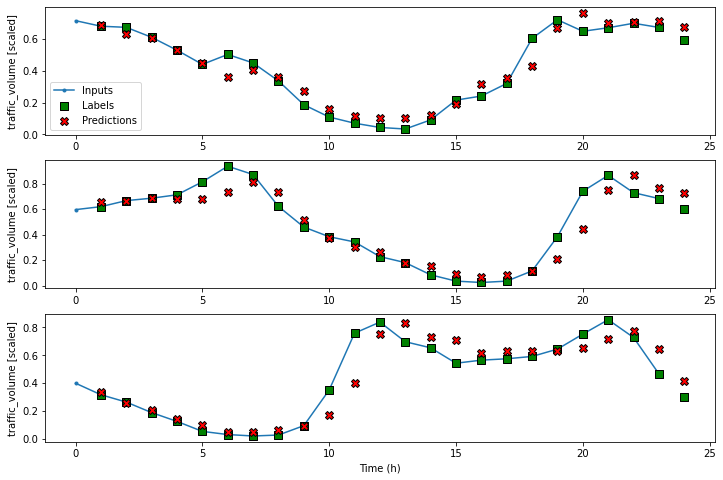

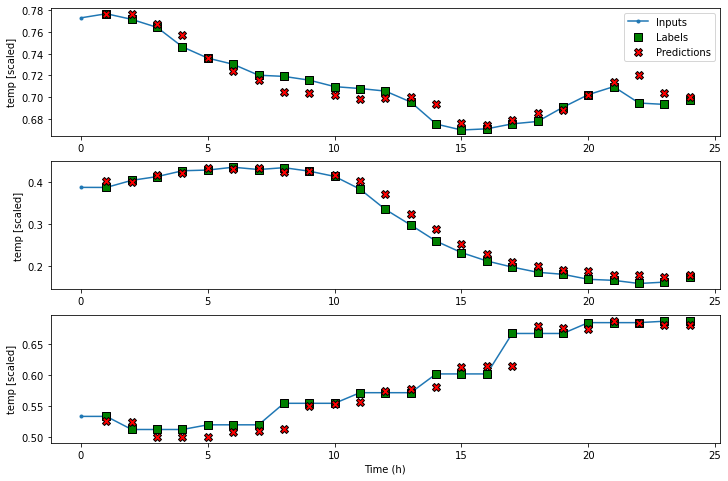

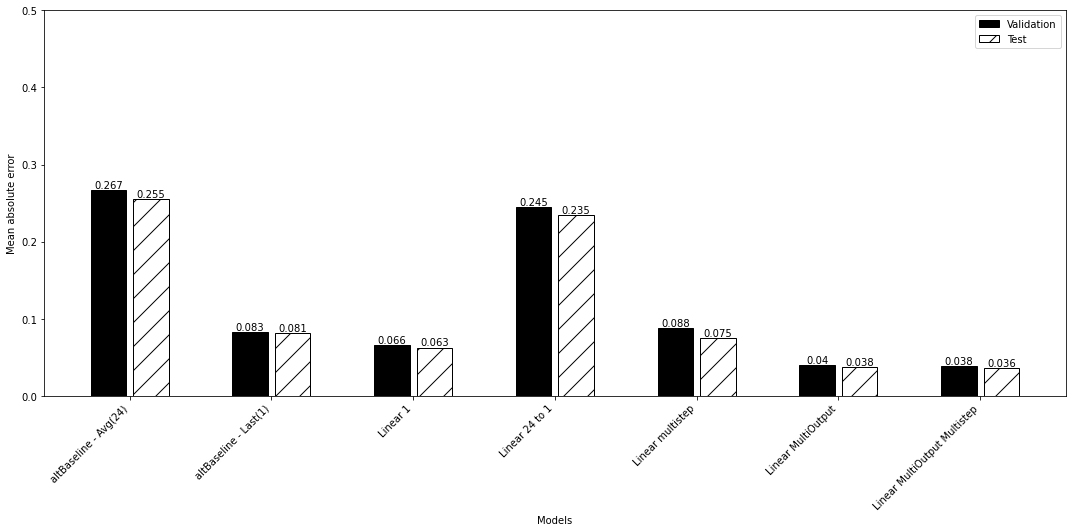

In [11]:


mos_linear = Sequential([
    Dense(units=2)
])

history = compile_and_fit(mos_linear, mo_wide_window)

val_performance['Linear MultiOutput Multistep'] = mos_linear.evaluate(mo_wide_window.val)
performance['Linear MultiOutput Multistep'] = mos_linear.evaluate(mo_wide_window.test, verbose=0)

mo_wide_window.plot(mos_linear)
mo_wide_window.plot(mos_linear,plot_col='temp')
print_perf()

Now let's talk about deep learning. A deep network is a network with intermediate layers of units 
these layers are called hidden. It results generally on models that generalize better. On the layers, 
each node has an activation function that is non-linear. We use here ReLU! 


<div style="background-color:white;">
    <br><br/>
    <img src="../figures/figure_deepL.png" alt="My Image">
</div>

Epoch 1/50
384/384 [==============================] - 3s 4ms/step - loss: 0.0135 - mean_absolute_error: 0.0773 - val_loss: 0.0057 - val_mean_absolute_error: 0.0583
Epoch 2/50
384/384 [==============================] - 2s 4ms/step - loss: 0.0048 - mean_absolute_error: 0.0520 - val_loss: 0.0039 - val_mean_absolute_error: 0.0474
Epoch 3/50
384/384 [==============================] - 2s 4ms/step - loss: 0.0039 - mean_absolute_error: 0.0465 - val_loss: 0.0034 - val_mean_absolute_error: 0.0440
Epoch 4/50
384/384 [==============================] - 1s 4ms/step - loss: 0.0037 - mean_absolute_error: 0.0451 - val_loss: 0.0034 - val_mean_absolute_error: 0.0448
Epoch 5/50
384/384 [==============================] - 2s 4ms/step - loss: 0.0034 - mean_absolute_error: 0.0425 - val_loss: 0.0028 - val_mean_absolute_error: 0.0400
Epoch 6/50
384/384 [==============================] - 1s 4ms/step - loss: 0.0032 - mean_absolute_error: 0.0418 - val_loss: 0.0027 - val_mean_absolute_error: 0.0385
Epoch 7/50
384/3

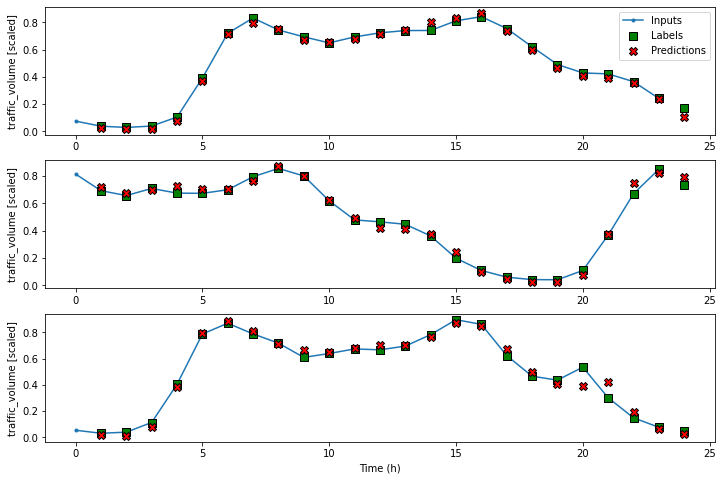

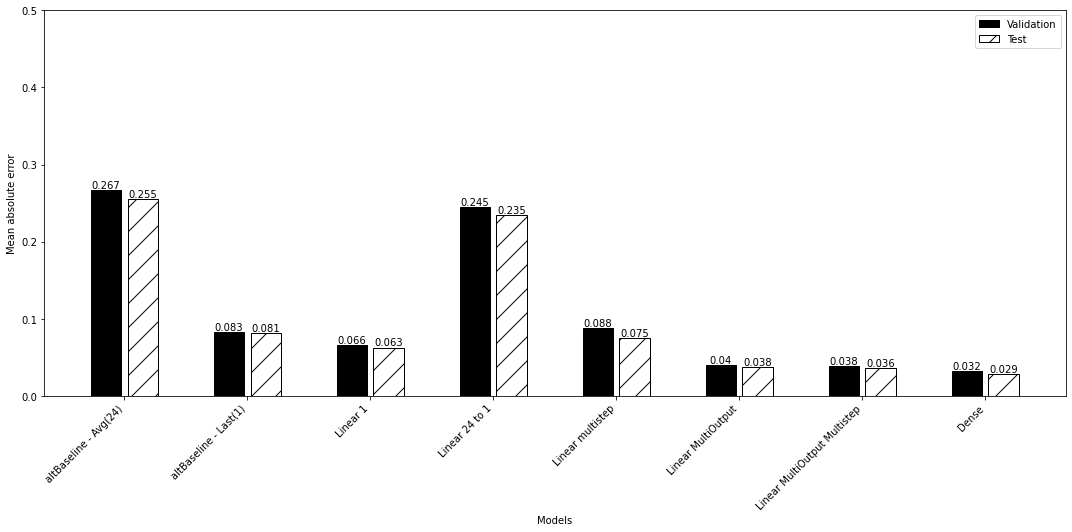

In [12]:
single_step_window = DataWindow(input_width=1, label_width=1, shift=1, label_columns=['traffic_volume']) 
dense = Sequential([
    Dense(units=64, activation='relu'),
    Dense(units=64, activation='relu'),
    Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)
wide_window.plot(dense)
print_perf()

Epoch 1/50
383/383 [==============================] - 3s 5ms/step - loss: 0.0293 - mean_absolute_error: 0.1095 - val_loss: 0.0165 - val_mean_absolute_error: 0.0837
Epoch 2/50
383/383 [==============================] - 2s 4ms/step - loss: 0.0140 - mean_absolute_error: 0.0786 - val_loss: 0.0157 - val_mean_absolute_error: 0.0836
Epoch 3/50
383/383 [==============================] - 2s 5ms/step - loss: 0.0136 - mean_absolute_error: 0.0776 - val_loss: 0.0155 - val_mean_absolute_error: 0.0849
Epoch 4/50
383/383 [==============================] - 2s 5ms/step - loss: 0.0133 - mean_absolute_error: 0.0769 - val_loss: 0.0157 - val_mean_absolute_error: 0.0821
Epoch 5/50
383/383 [==============================] - 2s 5ms/step - loss: 0.0132 - mean_absolute_error: 0.0764 - val_loss: 0.0148 - val_mean_absolute_error: 0.0810
Epoch 6/50
383/383 [==============================] - 2s 5ms/step - loss: 0.0131 - mean_absolute_error: 0.0761 - val_loss: 0.0149 - val_mean_absolute_error: 0.0790
Epoch 7/50
383/3

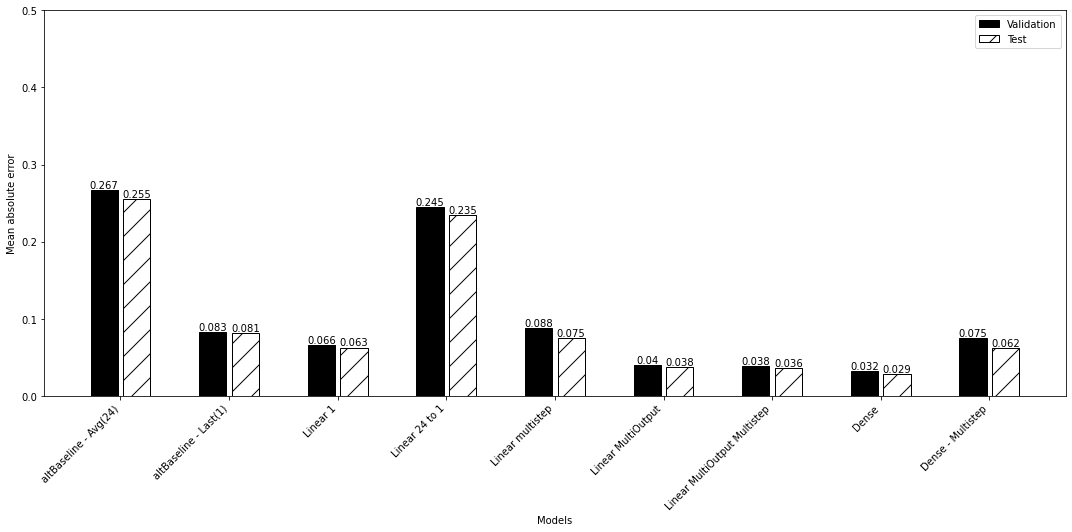

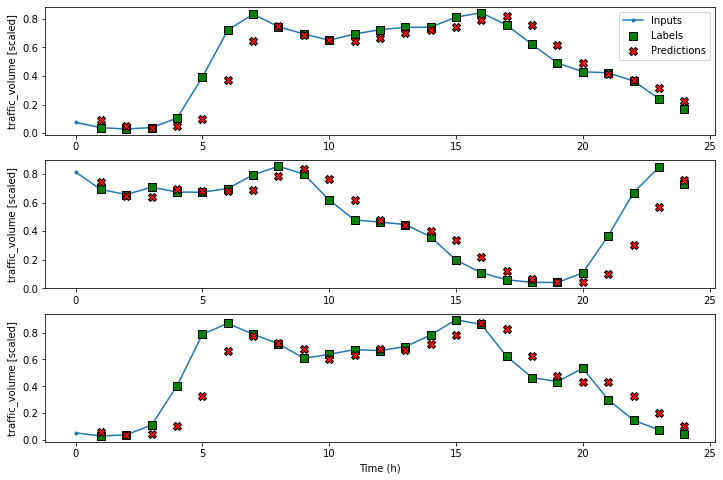

In [13]:
ms_dense = Sequential([
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(ms_dense, multi_window)

val_performance['Dense - Multistep'] = ms_dense.evaluate(multi_window.val)
performance['Dense - Multistep'] = ms_dense.evaluate(multi_window.test, verbose=0)
print_perf()
wide_window.plot(ms_dense)


Epoch 1/50
384/384 [==============================] - 12s 9ms/step - loss: 0.0126 - mean_absolute_error: 0.0623 - val_loss: 0.0029 - val_mean_absolute_error: 0.0345
Epoch 2/50
384/384 [==============================] - 3s 8ms/step - loss: 0.0029 - mean_absolute_error: 0.0339 - val_loss: 0.0021 - val_mean_absolute_error: 0.0298
Epoch 3/50
384/384 [==============================] - 3s 8ms/step - loss: 0.0024 - mean_absolute_error: 0.0307 - val_loss: 0.0022 - val_mean_absolute_error: 0.0314
Epoch 4/50
384/384 [==============================] - 3s 9ms/step - loss: 0.0021 - mean_absolute_error: 0.0288 - val_loss: 0.0018 - val_mean_absolute_error: 0.0274
Epoch 5/50
384/384 [==============================] - 4s 11ms/step - loss: 0.0020 - mean_absolute_error: 0.0277 - val_loss: 0.0016 - val_mean_absolute_error: 0.0252
Epoch 6/50
384/384 [==============================] - 5s 12ms/step - loss: 0.0019 - mean_absolute_error: 0.0270 - val_loss: 0.0016 - val_mean_absolute_error: 0.0253
Epoch 7/50
38

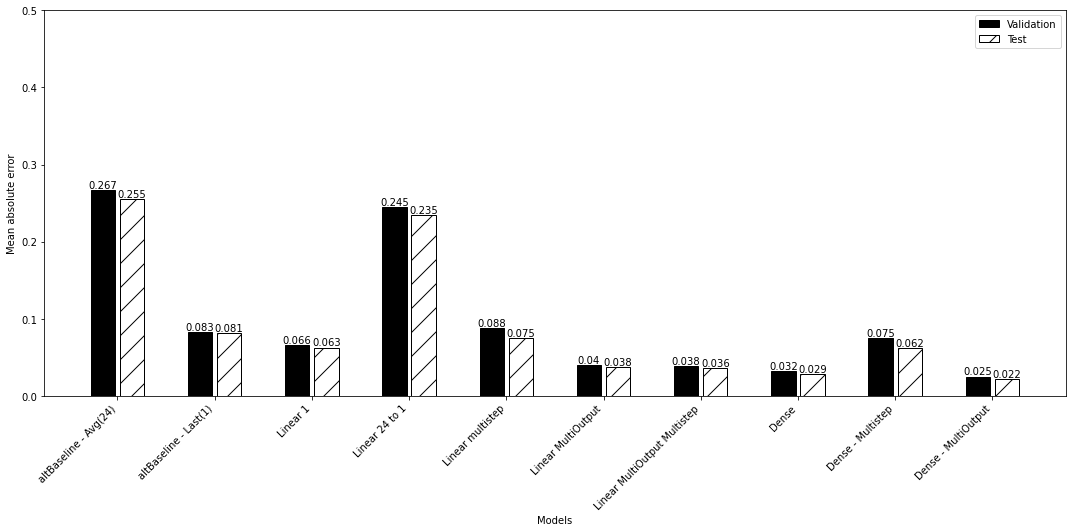

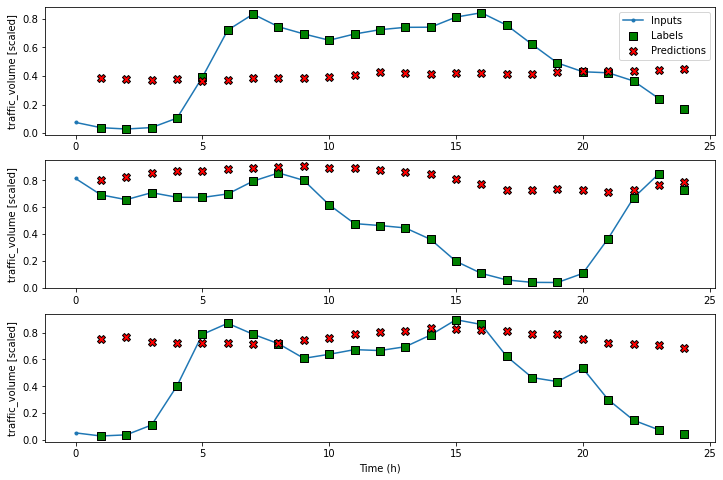

In [14]:
mo_dense = Sequential([
    Dense(units=64, activation='relu'),
    Dense(units=64, activation='relu'),
    Dense(units=2)
])

history = compile_and_fit(mo_dense, mo_single_step_window)

val_performance['Dense - MultiOutput'] = mo_dense.evaluate(mo_single_step_window.val)
performance['Dense - MultiOutput'] = mo_dense.evaluate(mo_single_step_window.test, verbose=0)
print_perf()
wide_window.plot(mo_dense)

In [15]:
import json
print(performance.keys())

perf_dict={}

keys_to_export = ['altBaseline - Avg(24)', 'Linear 24 to 1','altBaseline - Last(1)','Linear 1','Dense']
single_step={}
perf_single_step = {key: performance[key] for key in keys_to_export}
val_perf_single_step = {key: val_performance[key] for key in keys_to_export}
single_step["perf"]=perf_single_step
single_step["val_perf"]=val_perf_single_step

keys_to_export = ['Linear multistep', 'Dense - Multistep']
multi_step={}
perf_single_step = {key: performance[key] for key in keys_to_export}
val_perf_single_step = {key: val_performance[key] for key in keys_to_export}
multi_step["perf"]=perf_single_step
multi_step["val_perf"]=val_perf_single_step

keys_to_export = ['Linear MultiOutput', 'Linear MultiOutput Multistep','Dense - MultiOutput']
multi_out={}
perf_single_step = {key: performance[key] for key in keys_to_export}
val_perf_single_step = {key: val_performance[key] for key in keys_to_export}
multi_out["perf"]=perf_single_step
multi_out["val_perf"]=val_perf_single_step

perf_dict["single"]=single_step
perf_dict["multistep"]=multi_step
perf_dict["multi-output"]=multi_out
with open('../data/perf_dict.json', 'w') as f:
    json.dump(perf_dict, f)
    


dict_keys(['altBaseline - Avg(24)', 'altBaseline - Last(1)', 'Linear 1', 'Linear 24 to 1', 'Linear multistep', 'Linear MultiOutput', 'Linear MultiOutput Multistep', 'Dense', 'Dense - Multistep', 'Dense - MultiOutput'])
